# Causal discovery from observational and/or interventional data across multiple domains

Causal discovery algorithms such as the PC, FCI and GeS algorithm typically assume data is iid and come from a single distribution (i.e. a single domain). In the real world, causal structure is typically shared among similar domains, but the distributional functions may differ (e.g. one domain may have Gaussian noise, whereas another domain has Poisson noise).

The S-FCI algorithm is introduced as a constraint-based discovery method that is a generalization of the FCI algorithm and moreover a generalization of the I-FCI/$\Psi$-FCI algorithms. It correctly leverages data across distributions to learn a S-PAG, which is a Markov equivalence class of augmented selection diagrams. Augmented selection diagrams are selection diagrams with additional F-nodes indicating interventional distributions in any specified domain. 

Here, we demonstrate how the S-FCI algorithm typically learns more compared to its predecessors on simulated data stemming from a real experiment. 

This is done because one of the challenges of evaluating modern causal discovery is the lack of a suite of datasets that have multiple domains, and various types of interventions, and an accepted ground-truth graph.

## Pseudo-Real Data: Protein Sequencing Experiment

The famous Sachs dataset [2]_ is a wet-lab experiment dataset where protein expression level were observed in resting-state and then proteins were perturbed in various scenarios to obtain interventional data. This dataset can be viewed as observational and interventional data stemming from a single domain.

The ground truth graph that we will assume is true is: https://www.bnlearn.com/research/sachs05/

We will create an in-silico multi-domain dataset from the real data. We will do this by i) specifying at random nodes that are "latent", causing latent confounders and ii) choosing random nodes with S-nodes pointing to them causing shifts in distribution from source to target domain.

### Setup

The setup we will first consider the ground-truth graph

In [72]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [73]:
from IPython.display import display_svg

In [85]:
from pprint import pprint
import numpy as np
import scipy
import pandas as pd
import collections
from itertools import combinations
import bnlearn
import pooch
from cdt.data import load_dataset

from pywhy_graphs.functional import (
    make_graph_linear_gaussian,
    make_graph_multidomain,
    set_node_attributes_with_G,
    apply_linear_soft_intervention,
    sample_multidomain_lin_functions,
)
from pywhy_graphs.classes import AugmentedGraph
from pywhy_graphs.viz import draw

from dodiscover.cd import KernelCDTest
from dodiscover.ci import KernelCITest, FisherZCITest, Oracle, GSquareCITest
from dodiscover.constraint.skeleton import LearnMultiDomainSkeleton
from dodiscover.datasets import sample_from_graph

from dodiscover import PsiFCI, SFCI, Context, make_context, InterventionalContextBuilder

In [64]:
seed = 1234
rng = np.random.default_rng(seed)
n_jobs = -1

In [65]:
alpha = 0.05

# Load the data

In [5]:
# use pooch to download robustly from a url
url = "https://www.bnlearn.com/book-crc/code/sachs.interventional.txt.gz"
file_path = pooch.retrieve(
    url=url,
    known_hash="md5:39ee257f7eeb94cb60e6177cf80c9544",
)

df = pd.read_csv(file_path, delimiter=" ")

In [6]:
# download purely observational data
data = bnlearn.import_example(data='sachs', n=10000, verbose=3)

[bnlearn] >Extracting files..


In [7]:
print(data.head())
print(df.head())

   Erk  Akt  PKA  Mek  Jnk  PKC  Raf  P38  PIP3  PIP2  Plcg
0    1    0    1    1    0    0    1    0     2     0     0
1    2    1    2    0    0    0    0    0     1     0     0
2    0    0    0    0    1    1    0    0     2     0     0
3    1    0    1    1    0    1    0    0     0     1     2
4    1    1    1    0    1    1    0    0     2     0     0
   Raf  Mek  Plcg  PIP2  PIP3  Erk  Akt  PKA  PKC  P38  Jnk  INT
0    1    1     1     2     3    2    1    3    1    2    1    8
1    1    1     1     1     3    3    2    3    1    2    1    8
2    1    1     2     2     3    2    1    3    2    1    1    8
3    1    1     1     1     3    2    1    3    1    3    1    8
4    1    1     1     1     3    2    1    3    1    1    1    8


In [8]:
perturbations = [df.columns[perturbed_col] for perturbed_col in df['INT'].unique()]

print(perturbations)

['PKC', 'Raf', 'PKA', 'P38', 'PIP3', 'Plcg']


In [9]:
# the ground-truth dag is shown here: XXX: comment in when errors are fixed
ground_truth_dag = bnlearn.import_DAG("sachs", verbose=False)

In [11]:
ground_truth_G = ground_truth_dag['model'].to_directed()
G = draw(ground_truth_G, direction='TD', shape='circle')
G.render(
    outfile="/Users/adam2392/Dropbox/Apps/Overleaf/Learning selection diagrams (observational)/Figures/Appendix/ground_truth_sachs_bnlearn.pdf",
    format="pdf",
    cleanup=True,
)

'/Users/adam2392/Dropbox/Apps/Overleaf/Learning selection diagrams (observational)/Figures/Appendix/ground_truth_sachs_bnlearn.pdf'

# Linear SCM Simulation: Generate Ground-Truth Data

First, we assume the causal diagram is induced by a linear SCM. In this setting, we are able to test the performance of S-FCI vs other algorithms when we artificially introduce differnet domain settings that simulate the collection of observations and experiments across e.g. different labs, and hospitals.

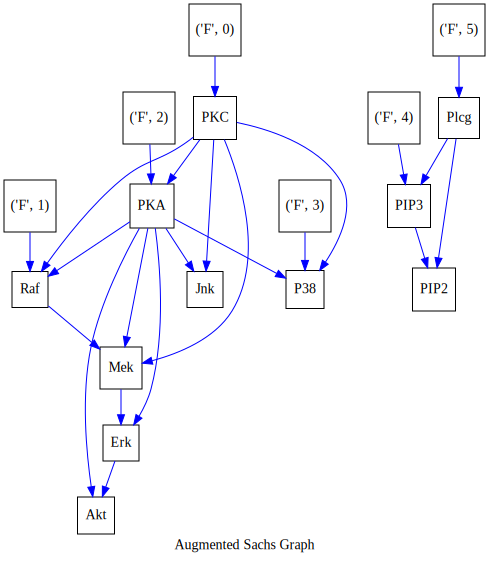

In [19]:
aug_graph = AugmentedGraph(incoming_directed_edges=ground_truth_G.copy())

# add perturbations
for node in perturbations:
    aug_graph.add_f_node({node}, domain=1)

draw(aug_graph, name='Augmented Sachs Graph')

In [36]:
node_mean_lims = [-1, 1]
node_std_lims = [0.01, 1.5]
edge_functions = [lambda x: x, lambda x: x**2]
edge_weight_lims = [-0.5, 0.5]

n_domains = 5

In [37]:
n_samples = 1000

In [38]:
# convert graph to linear functional graph
aug_lin_graph = make_graph_linear_gaussian(
    aug_graph,
    node_mean_lims=node_mean_lims,
    node_std_lims=node_std_lims,
    edge_functions=edge_functions,
    edge_weight_lims=edge_weight_lims,
    random_state=seed,
)
md_lin_graph = sample_multidomain_lin_functions(
    aug_lin_graph,
    n_domains=n_domains,
    node_mean_lims=node_mean_lims,
    node_std_lims=node_std_lims,
    edge_functions=edge_functions,
    edge_weight_lims=edge_weight_lims,
    random_state=seed,
)

In [40]:
domain_indices = []
intervention_targets = []
# mechanisms = []
data = []

for idx, domain_id in enumerate(range(1, n_domains + 1)):
    df = sample_from_graph(
        md_lin_graph,
        sample_func="multidomain",
        n_samples=n_samples,
        n_jobs=1,
        random_state=seed,
        domain_id=domain_id,
    )

    domain_indices.append(domain_id)
    intervention_targets.append({})
    data.append(df)

    for perturbation in perturbations:
        int_graph = md_lin_graph.copy()

        # generate a soft-intervention
        int_graph = apply_linear_soft_intervention(
            int_graph, targets={perturbation}, random_state=seed
        )

        # sample data from the intervention distribution
        df = sample_from_graph(
            int_graph,
            sample_func="multidomain",
            n_samples=n_samples,
            n_jobs=1,
            random_state=seed,
            domain_id=domain_id,
        )
        domain_indices.append(domain_id)
        intervention_targets.append({perturbation})
        data.append(df)

In [59]:
# generate single-domain data
single_domain_data = []
single_domain_targets = []

seen_indices = set()
for targets in intervention_targets:
    indices = [
        idx
        for idx in range(len(domain_indices))
        if intervention_targets[idx] == targets
    ]
    if any(idx in seen_indices for idx in indices):
        continue
    for idx in indices:
        seen_indices.add(idx)

    single_domain_data.append(pd.concat([data[idx] for idx in indices], axis=0))
    if targets == {}:
        continue
    single_domain_targets.append(targets)

print(single_domain_targets)
print(len(single_domain_targets))

[{'PKC'}, {'Raf'}, {'PKA'}, {'P38'}, {'PIP3'}, {'Plcg'}]
6


## Analysis

### With I-FCI

In [60]:
context = (
    make_context(create_using=InterventionalContextBuilder)
    .variables(aug_graph.non_augmented_nodes)
    # .obs_distribution(False)
    .intervention_targets(single_domain_targets)
    # .mechanisms([{"x": 1}, {"x": 2}])
    .num_distributions(len(single_domain_data))
    .build()
)

In [70]:
# IFCI
learner = PsiFCI(
    ci_estimator=FisherZCITest(),
    cd_estimator=KernelCDTest(),
    alpha=alpha,
    known_intervention_targets=True,
)
learner.fit(
    single_domain_data,
    context,
)

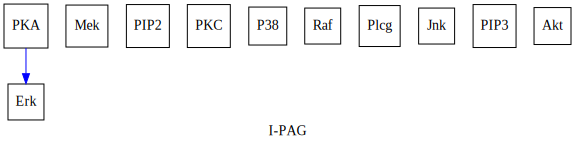

In [75]:
ifci_g = draw(learner.graph_.subgraph(aug_graph.non_augmented_nodes), name="I-PAG")
ifci_g.render(
    outfile="./sachs-ifci.pdf",
    format="pdf",
    cleanup=True,
)
display_svg(ifci_g)

### With S-FCI

In [76]:
context = (
    make_context(create_using=InterventionalContextBuilder)
    .variables(aug_graph.non_augmented_nodes)
    .num_distributions(len(data))
    .build()
)

In [82]:
# now learn the relationships
learner = SFCI(
    ci_estimator=FisherZCITest(), cd_estimator=KernelCDTest(), alpha=alpha, debug=False,
    n_jobs=-1
)

In [83]:
learner.fit(
    data,
    context,
    domain_indices=domain_indices,
    intervention_targets=intervention_targets,
)

KeyboardInterrupt: 

In [ ]:
draw(learner.graph_.subgraph(aug_graph.non_augmented_nodes))

In [ ]:
pprint(learner.separating_sets_)

# Generating Artificial Domains Via Dirichlet Perturbation

Next, we do not assume we can specify the true SCM of the Sachs dataset. Instead of completely specifying the data-generating model for the Sachs dataset, we now apply perturbations to the dataset that is commonly used to evaluate algorithms, such as the FCI, I-FCI, $\Psi$-FCI in a single-domain setting. 

To simulate a multi-domain setting from the data, we will generate a random graph from the ground-truth
that contains S-nodes. S-nodes are added randomly to simulate a change in mechanism. S-nodes will perturb the node it is pointing to with a dirichlet distribution that perturbs the discrete distribution of the protein expression levels. In order to maintain consistency of the change in domain, all descendants of the S-node will get perturbed slightly.

In [10]:
print(ground_truth_G.number_of_nodes())

11


In [11]:
print(data.head())

   Erk  Akt  PKA  Mek  Jnk  PKC  Raf  P38  PIP3  PIP2  Plcg
0    1    0    1    0    1    1    0    0     1     0     0
1    2    1    1    0    1    1    0    0     1     0     1
2    1    0    1    0    1    0    0    0     2     0     0
3    1    0    2    0    0    0    1    0     0     0     0
4    1    0    2    0    0    0    1    0     2     0     0


In [12]:
# initialize list of domain dataframes
domain_dfs = []
domain_dfs.append(df.copy())
all_s_nodes = []


## (Optional) Choose Latent Confounders

In [13]:
# choose a random node to delete to add latent confounders
node_delete = rng.choice(ground_truth_G.nodes)
node_delete = []
print(node_delete)

[]


## Generate Second Domain Dataset

In [14]:
n_domains = 2

In [15]:
G = ground_truth_G.copy()

In [16]:
sdx = 0
s_nodes = []
s_node_domains = collections.defaultdict(list)

# first, add all the S-nodes representing differences across pairs of domains
for domains in combinations(range(1, n_domains+1), 2):
    source_domain, target_domain = sorted(domains)

    # choose a random number of S-nodes to add between (source, target)
    n_s_nodes = rng.integers(0, 3)
    print(n_s_nodes)
    s_nodes_pointer = rng.choice(G.nodes, size=n_s_nodes, replace=False)

    # now modify the function of the edge, S-nodes are pointing to
    s_node = ('S', sdx)
    s_nodes.append(s_node)
    G.add_node(s_node, domain_ids=(source_domain, target_domain))
    for node in s_nodes_pointer:
        # the source domain is always the "reference" distribution, that is
        # the one we keep fixed
        G.add_edge(s_node, node)
        print('Adding edge... ', s_node, node)
        # mape each source to its target and corresponding S-nodes
        s_node_domains[source_domain].append((target_domain, node, s_node))
    sdx +=1

2
Adding edge...  ('S', 0) Jnk
Adding edge...  ('S', 0) PIP2


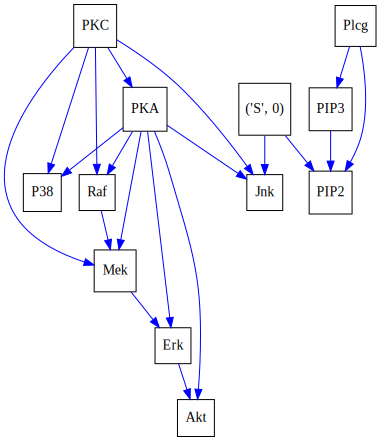

In [17]:
draw(G, direction='TD')

In [18]:
# generate a random linear SCM dataset from the accepted ground-truth
ground_truth_G_lin_lab = make_graph_linear_gaussian(ground_truth_G, random_state=seed)

In [19]:
non_s_nodes = set(ground_truth_G_lin_lab.nodes).difference(set(s_nodes))
# generate a dataset with invariances across domain
ground_truth_G_lin_hospital = make_graph_linear_gaussian(ground_truth_G, random_state=seed)
for node in non_s_nodes:
    ground_truth_G_lin_hospital = set_node_attributes_with_G(ground_truth_G_lin_hospital, ground_truth_G_lin_hospital, node)


In [20]:
data = []
domain_ids = []
intervention_targets = []

In [21]:
# sample both datasets
lab_dataset = linear.sample_from_graph(ground_truth_G_lin_lab, n_samples=1000,
                         n_jobs=n_jobs)
hospital_dataset = linear.sample_from_graph(ground_truth_G_lin_hospital, n_samples=1000,
                         n_jobs=n_jobs)

data.extend([lab_dataset, hospital_dataset])
domain_ids.extend([1, 2])
intervention_targets.extend([set(), set()])

In [25]:

# apply perturbations in the lab setting
for target in perturbations:
    # apply soft intervention
    G = apply_soft_intervention(ground_truth_G_lin_lab, targets={target}, random_state=seed)
    df = linear.sample_from_graph(ground_truth_G_lin_hospital, n_samples=1000,
                         n_jobs=n_jobs)
    
    data.append(df)
    domain_ids.append(1)
    intervention_targets.append(target)
    
# apply one perturbation in the hospital setting


## $\Psi$-FCI analysis

Since, $\Psi$-FCI is the most general learning algorithm that accounts for interventions and observational data, we will leverage this as a naive baseline.

In [26]:
n_distributions = len(data)

In [27]:
ci_estimator = KernelCITest()

# Since our data is entirely discrete, we can also use the G^2 test as our
# CD test.
cd_estimator = KernelCDTest()


In [28]:
alpha = 0.05
learner = PsiFCI(ci_estimator=ci_estimator, cd_estimator=cd_estimator, alpha=alpha, n_jobs=-1)

# create context with information about the interventions
ctx_builder = make_context(create_using=InterventionalContextBuilder)
ctx: Context = (
    ctx_builder.variables(data=data[0]).num_distributions(n_distributions).obs_distribution(False).build()
)

In [ ]:
learner = learner.fit(data, ctx)

In [ ]:
est_pag = learner.graph_

print(f"There are {len(est_pag.to_undirected().edges)} edges in the resulting PAG")

# %%
# Visualize the graph without the F-nodes
est_pag_no_fnodes = est_pag.subgraph(ctx.get_non_augmented_nodes())
dot_graph = draw(est_pag_no_fnodes, direction="LR")
dot_graph.render(outfile="psi_pag.png", view=True)

### S-FCI analysis

Next, we run S-FCI to compare the outputs of the two algorithms

# Comparing Outputs

[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


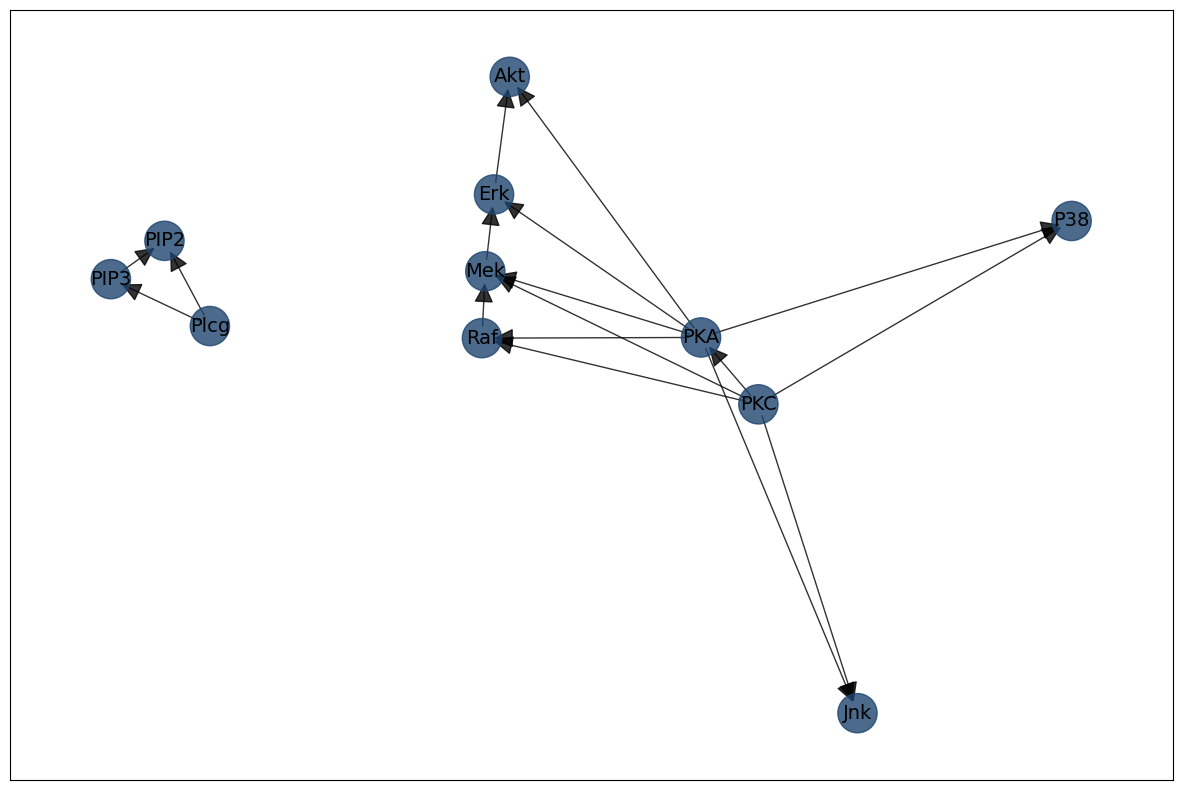

   Raf  Mek  Plcg  PIP2  PIP3  Erk  Akt  PKA  PKC  P38  Jnk  INT
0    1    1     1     2     3    2    1    3    1    2    1    8
1    1    1     1     1     3    3    2    3    1    2    1    8
2    1    1     2     2     3    2    1    3    2    1    1    8
3    1    1     1     1     3    2    1    3    1    3    1    8
4    1    1     1     1     3    2    1    3    1    1    1    8
(5400, 12)


In [86]:
# use pooch to download robustly from a url
url = "https://www.bnlearn.com/book-crc/code/sachs.interventional.txt.gz"
file_path = pooch.retrieve(
    url=url,
    known_hash="md5:39ee257f7eeb94cb60e6177cf80c9544",
)

df = pd.read_csv(file_path, delimiter=" ")

# the ground-truth dag is shown here: XXX: comment in when errors are fixed
ground_truth_dag = bnlearn.import_DAG("sachs", verbose=False)
fig = bnlearn.plot(ground_truth_dag)

# .. note::
#    The Sachs dataset has previously been preprocessed, and the steps are described
#    in bnlearn, at the web-page https://www.bnlearn.com/research/sachs05/.
print(df.head())
print(df.shape)

In [113]:
# %%
# Preprocess the dataset
# ----------------------
# Since the data is one dataframe, we need to process it into a form
# that is acceptable by dodiscover's :class:`constraint.PsiFCI` algorithm. We
# will form a list of separate dataframes.
unique_ints = df["INT"].unique()

# get the list of intervention targets and list of dataframe associated with each intervention
intervention_targets = [df.columns[idx] for idx in unique_ints]
data_cols = [col for col in df.columns if col != "INT"]
data = []
domain_ids = np.array([0, 0, 0, 0, 0, 1])
for interv_idx in unique_ints:
    _data = df[df["INT"] == interv_idx][data_cols]
    data.append(_data)

print(len(data), len(intervention_targets), len(domain_ids))
# %%
# Setup constraint-based learner
# ------------------------------
# Since we have access to interventional data, the causal discovery algorithm
# we will use that leverages CI and CD tests to estimate causal constraints
# is the Psi-FCI algorithm :footcite:`Jaber2020causal`.

# Our dataset is comprised of discrete valued data, so we will utilize the
# G^2 (Chi-square) CI test.
ci_estimator = GSquareCITest(data_type="discrete")

# Since our data is entirely discrete, we can also use the G^2 test as our
# CD test.
cd_estimator = GSquareCITest(data_type="discrete")

alpha = 0.8
learner = SFCI(
    ci_estimator=ci_estimator, cd_estimator=cd_estimator, alpha=alpha, n_jobs=-1
)

# create context with information about the interventions
ctx_builder = make_context(create_using=InterventionalContextBuilder)
ctx: Context = ctx_builder.variables(data=data[0]).num_distributions(len(data)).build()

print(ctx.init_graph)

# %%
# Run the learning process
# ------------------------
# We have setup our causal context and causal discovery learner, so we will now
# run the algorithm using the :meth:`constraint.PsiFCI.fit` API, which is similar to scikit-learn's
# `fit` design. All fitted attributes contain an underscore at the end.
learner = learner.fit(
    data, ctx, domain_indices=domain_ids, intervention_targets=intervention_targets
)

# %%
# Analyze the results
# ===================
# Now that we have learned the graph, we will show it here. Note differences and similarities
# to the ground-truth DAG that is "assumed". Moreover, note that this reproduces Supplementary
# Figure 8 in :footcite:`Jaber2020causal`.
est_pag = learner.graph_

print(f"There are {len(est_pag.to_undirected().edges)} edges in the resulting PAG")

# %%
# Visualize the full graph including the F-node
# dot_graph = draw(est_pag, direction="LR")
# dot_graph.render(outfile="_pag_full.png", view=True)

# %%
# Visualize the graph without the F-nodes
est_pag_no_fnodes = est_pag.subgraph(data_cols)
dot_graph = draw(est_pag_no_fnodes, direction="LR")
dot_graph.render(outfile="s_pag.png", view=True)

6 6 6
Graph with 26 nodes and 325 edges
There are 284 edges in the resulting PAG


's_pag.png'

In [114]:
# Setup constraint-based learner
# ------------------------------
# Since we have access to interventional data, the causal discovery algorithm
# we will use that leverages CI and CD tests to estimate causal constraints
# is the Psi-FCI algorithm :footcite:`Jaber2020causal`.

# Our dataset is comprised of discrete valued data, so we will utilize the
# G^2 (Chi-square) CI test.
ci_estimator = GSquareCITest(data_type="discrete")

# Since our data is entirely discrete, we can also use the G^2 test as our
# CD test.
cd_estimator = GSquareCITest(data_type="discrete")

alpha = 0.05
learner = PsiFCI(
    ci_estimator=ci_estimator, cd_estimator=cd_estimator, alpha=alpha, n_jobs=-1
)

# create context with information about the interventions
ctx_builder = make_context(create_using=InterventionalContextBuilder)
ctx: Context = (
    ctx_builder.variables(data=data[0])
    .num_distributions(6)
    .obs_distribution(False)
    .build()
)

print(ctx.init_graph)
print(ctx.f_nodes)

# %%
# Run the learning process
# ------------------------
# We have setup our causal context and causal discovery learner, so we will now
# run the algorithm using the :meth:`constraint.PsiFCI.fit` API, which is similar to scikit-learn's
# `fit` design. All fitted attributes contain an underscore at the end.
learner = learner.fit(data, ctx)

# %%
# Analyze the results
# ===================
# Now that we have learned the graph, we will show it here. Note differences and similarities
# to the ground-truth DAG that is "assumed". Moreover, note that this reproduces Supplementary
# Figure 8 in :footcite:`Jaber2020causal`.
est_pag = learner.graph_

print(f"There are {len(est_pag.to_undirected().edges)} edges in the resulting PAG")

# %%
# Visualize the full graph including the F-node
dot_graph = draw(est_pag, direction="LR")
dot_graph.render(outfile="psi_pag_full.png", view=True)

# %%
# Visualize the graph without the F-nodes
est_pag_no_fnodes = est_pag.subgraph(ctx.get_non_augmented_nodes())
dot_graph = draw(est_pag_no_fnodes, direction="LR")
dot_graph.render(outfile="psi_pag.png", view=True)

Graph with 26 nodes and 325 edges
[('F', 0), ('F', 1), ('F', 2), ('F', 3), ('F', 4), ('F', 5), ('F', 6), ('F', 7), ('F', 8), ('F', 9), ('F', 10), ('F', 11), ('F', 12), ('F', 13), ('F', 14)]
There are 167 edges in the resulting PAG


'psi_pag.png'